In [ ]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Dataset/data/dataset.zip' -d '/content/Dataset/'

In [ ]:
# import shutil
# import os

# # Define the path to the folder you want to empty and delete
# folder_path = '/content/Dataset'  # Replace with the path to your folder

# # Function to empty a folder
# def empty_folder(folder_path):
#     for filename in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, filename)
#         try:
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)
#         except Exception as e:
#             print(f"Failed to delete {file_path}: {e}")

# # Empty the folder
# empty_folder(folder_path)

# # Delete the empty folder
# os.rmdir(folder_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
train_dir = '/content/Dataset/test'
val_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/val'


In [ ]:
batch_size = 32
epochs = 10
target_size = (150, 150)  # Adjust the size as needed


In [ ]:
import os

def count_images_in_directories(parent_directory):
    image_counts = {}

    for root, _, files in os.walk(parent_directory):
        if files:
            subdirectory = os.path.relpath(root, parent_directory)
            image_counts[subdirectory] = image_counts.get(subdirectory, 0) + len(files)

    return image_counts

if __name__ == "__main__":
    parent_directory = '/content/Dataset/train/'  # Replace with your parent directory path
    image_counts = count_images_in_directories(parent_directory)

    for subdirectory, count in image_counts.items():
        print(f"Subdirectory '{subdirectory}': {count} images")

Subdirectory 'TURBERCULOSIS': 999 images
Subdirectory 'PNEUMONIA': 1000 images
Subdirectory 'NORMAL': 1000 images
Subdirectory 'COVID19': 966 images


In [ ]:
import os

def remove_extra_images_from_folders(main_directory, max_images_per_folder=1000):
    # Iterate through subdirectories in the main directory
    for folder_name in os.listdir(main_directory):
        folder_path = os.path.join(main_directory, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder_name}")

            # List all files in the folder
            files = os.listdir(folder_path)

            # Check if there are more than max_images_per_folder
            if len(files) <= max_images_per_folder:
                print(f"No extra images found in '{folder_name}'")
                continue

            # Sort files by modification time (oldest first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))

            # Determine the number of excess images to remove
            num_excess_images = len(files) - max_images_per_folder

            # Remove excess images
            for i in range(num_excess_images):
                file_to_remove = os.path.join(folder_path, files[i])
                os.remove(file_to_remove)
                print(f"Removed: {file_to_remove}")

if __name__ == "__main__":
    main_directory = '/content/Dataset/train'  # Replace with your main directory path
    max_images_per_folder = 1000  # Change this value as needed
    remove_extra_images_from_folders(main_directory, max_images_per_folder)


Processing folder: TURBERCULOSIS
No extra images found in 'TURBERCULOSIS'
Processing folder: PNEUMONIA
Removed: /content/Dataset/train/PNEUMONIA/person1000_bacteria_2931.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1000_virus_1681.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1001_bacteria_2932.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person110_virus_205.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1058_virus_1757.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1099_bacteria_3040.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person108_virus_199.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person100_virus_184.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1141_bacteria_3084.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1018_bacteria_2949.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1116_virus_1841.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1101_bacteria_3042.jpeg
Removed: /content/Dataset/train/PNEUMONIA/person1054_bact

In [ ]:
import os

def count_images_in_directories(parent_directory):
    image_counts = {}

    for root, _, files in os.walk(parent_directory):
        if files:
            subdirectory = os.path.relpath(root, parent_directory)
            image_counts[subdirectory] = image_counts.get(subdirectory, 0) + len(files)

    return image_counts

if __name__ == "__main__":
    parent_directory = '/content/Dataset/train/'  # Replace with your parent directory path
    image_counts = count_images_in_directories(parent_directory)

    for subdirectory, count in image_counts.items():
        print(f"Subdirectory '{subdirectory}': {count} images")

Subdirectory 'TURBERCULOSIS': 999 images
Subdirectory 'PNEUMONIA': 1000 images
Subdirectory 'NORMAL': 1000 images
Subdirectory 'COVID19': 966 images


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
import math

def augment_and_balance_images_in_folders(parent_directory, target_image_count=1000, max_augmented_per_image=10):
    # Step 1: Iterate through subdirectories in the parent directory
    for folder_name in os.listdir(parent_directory):
        folder_path = os.path.join(parent_directory, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder_name}")

            # Step 2: Count images in the folder
            image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
            current_image_count = len(image_files)

            # Skip folders already containing the desired number of images
            if current_image_count >= target_image_count:
                print(f"'{folder_name}' already has {current_image_count} images. Skipping augmentation.")
                continue

            # Step 3: Create an ImageDataGenerator for data augmentation
            augmentation_params = {
                'rotation_range': 40,
                'width_shift_range': 0.2,
                'height_shift_range': 0.2,
                'shear_range': 0.2,
                'zoom_range': 0.2,
                'horizontal_flip': True,
                'fill_mode': 'nearest'
            }
            datagen = ImageDataGenerator(**augmentation_params)

            # Step 4: Load and preprocess images for augmentation
            while current_image_count < target_image_count:
                img_filename = image_files[0]  # Take the first image
                img_path = os.path.join(folder_path, img_filename)
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Generate and save up to max_augmented_per_image augmented images
                augmented_count = 0
                for i, batch in enumerate(datagen.flow(x, batch_size=1)):
                    if augmented_count >= max_augmented_per_image:
                        break  # Limit reached
                    if current_image_count >= target_image_count:
                        break  # Stop augmenting if the target count is reached

                    augmented_img_array = img_to_array(batch[0], dtype='uint8')
                    augmented_img = Image.fromarray(augmented_img_array)
                    augmented_img.save(os.path.join(folder_path, f"augmented_{i}_{img_filename}"))
                    augmented_count += 1
                    current_image_count += 1

                # Remove the original image to make space for augmented images
                os.remove(img_path)
                image_files.pop(0)

            print(f"Augmented '{folder_name}' to reach {target_image_count} images.")

if __name__ == "__main__":
    parent_directory = '/content/Dataset/train'  # Replace with your parent directory path
    target_image_count = 1000  # Change this value as needed
    max_augmented_per_image = 10  # Maximum augmented images per original image
    augment_and_balance_images_in_folders(parent_directory, target_image_count, max_augmented_per_image)

Processing folder: TURBERCULOSIS
Augmented 'TURBERCULOSIS' to reach 1000 images.
Processing folder: PNEUMONIA
'PNEUMONIA' already has 1000 images. Skipping augmentation.
Processing folder: NORMAL
'NORMAL' already has 1000 images. Skipping augmentation.
Processing folder: COVID19
Augmented 'COVID19' to reach 1000 images.


In [ ]:
import zipfile

# Define the source directory to be zipped
source_directory = "/content/Dataset"

# Define the name for the zip file
zip_file_name = "your_dataset.zip"

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, source_directory)
            zipf.write(file_path, arcname=arcname)

# Move the zip file to a desired location (e.g., Google Drive)
import shutil
destination_directory = "/content/drive/My Drive/Dataset/"
shutil.move(zip_file_name, os.path.join(destination_directory, zip_file_name))


'/content/drive/My Drive/Dataset/your_dataset.zip'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 771 images belonging to 4 classes.
Found 3965 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
25/25 [==============================] - 74s 3s/step - loss: 1.9459 - accuracy: 0.4462 - val_loss: 1.4558 - val_accuracy: 0.2522
Epoch 2/10
25/25 [==============================] - 58s 2s/step - loss: 1.1254 - accuracy: 0.4916 - val_loss: 1.6150 - val_accuracy: 0.2522
Epoch 3/10
25/25 [==============================] - 57s 2s/step - loss: 1.0044 - accuracy: 0.5409 - val_loss: 1.3439 - val_accuracy: 0.5887
Epoch 4/10
25/25 [==============================] - 57s 2s/step - loss: 0.9582 - accuracy: 0.5616 - val_loss: 1.2083 - val_accuracy: 0.5087
Epoch 5/10
25/25 [==============================] - 57s 2s/step - loss: 0.8833 - accuracy: 0.6057 - val_loss: 1.2329 - val_accuracy: 0.5319
Epoch 6/10
25/25 [==============================] - 56s 2s/step - loss: 0.8341 - accuracy: 0.6472 - val_loss: 1.2100 - val_accuracy: 0.6638
Epoch 7/10
25/25 [==============================] - 93s 4s/step - loss: 0.8176 - accuracy: 0.6342 - val_loss: 1.1254 - val_accuracy: 0.5692
Epoch 8/10
25/25 [==

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

2/2 [==============================] - 0s 174ms/step - loss: 0.9014 - accuracy: 0.7895
Test loss: 0.9014
Test accuracy: 0.7895


In [ ]:
model.save("ChestXray.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model("ChestXray.h5")

1/1 [==============================] - 0s 21ms/step
Predicted class: NORMAL


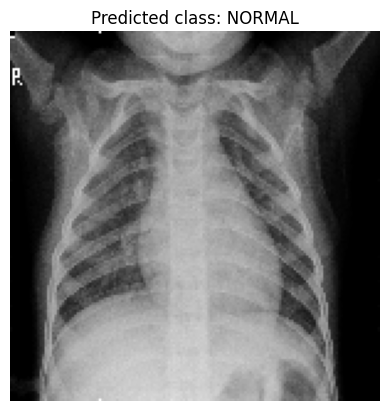

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/Dataset/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(150, 150))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["COVID19", "NORMAL", "PNEUMONIA","TUBERCULOSIS"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
# Assuming you have a list of class labels
class_labels = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]  # Replace with your actual class labels

# Make a prediction
predictions = loaded_model.predict(img)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")


1/1 [==============================] - 0s 19ms/step
Predicted class: COVID19


UNET Model for Image Segmentation